**Author:** Matt Sarmiento

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Datasets" data-toc-modified-id="Datasets-1">Datasets</a></span></li><li><span><a href="#Data-Wrangle" data-toc-modified-id="Data-Wrangle-2">Data Wrangle</a></span></li><li><span><a href="#Chasm-Plot" data-toc-modified-id="Chasm-Plot-3">Chasm Plot</a></span></li></ul></div>

In [1]:
# Third-party imports
import numpy as np
import pandas as pd

# Local modules
import mydata

In [2]:
# Load rpy2 extension (may need to re-run)
%reload_ext rpy2.ipython

In [3]:
# Load R libraries
%R library(ggplot2)
%R library(scales)

array(['scales', 'ggplot2', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], dtype='<U9')

--------------------

# Datasets

We'll look at the `sf-montgomery-opioid-deaths` dataset, which contains overdose counts due to opioids for ages 15-64 in two counties:
* San Francisco, CA
* Montgomery, OH

-------------------

# Data Wrangle

In [4]:
# Load data
sf_montg = pd.read_csv('../input/sf-montgomery-opioid-deaths.csv', sep='\t')
sf_montg.head(3)

,Notes,Year,Year Code,County,County Code,Deaths,Population,Crude Rate,Age Adjusted Rate
0,NaN,1999.0,1999.0,"San Francisco County, CA",6075.0,63.0,573477.0,11.0,11.2
1,NaN,1999.0,1999.0,"Montgomery County, OH",39113.0,23.0,369069.0,6.2,6.3
2,NaN,2000.0,2000.0,"San Francisco County, CA",6075.0,30.0,576612.0,5.2,5.6


In [5]:
# Only look at 2012 - 2017 data
sf_montg = sf_montg.loc[sf_montg.Year >= 2012]

# Renames col for ease of referencing in ggplot
sf_montg = sf_montg.rename(columns={'Age Adjusted Rate': 'Rate'})

# Casts Rate col from stirng to floats
sf_montg['Rate'] = mydata.series2float(sf_montg.Rate)

# Rounds rate and casts to int (for better viewing in ggplot)
sf_montg['Rate'] = np.round(sf_montg.Rate, 0).astype(int)

# Casts County col to Categorical to fix ordering
order = ['San Francisco County, CA', 'Montgomery County, OH']
sf_montg['County'] = pd.Categorical(sf_montg.County, categories=order, ordered=True)

In [6]:
# Select cols we want
sf_montg = sf_montg[['Year', 'County', 'Deaths', 'Rate']]

----------------

# Chasm Plot

In [7]:
%R -i sf_montg

In [8]:
%%R


# Custom theme
theme_custom <- theme(text = element_text(family = "sans"),
                      panel.grid = element_blank(),
                      plot.title = element_text(face = "bold", size = 20, hjust = 0.02),
                      plot.subtitle = element_text(colour = "grey40", size = 16, hjust = 0.01),
                      plot.margin = unit(c(1, 0.5, 1, 0.5), "cm"),
                      strip.text = element_text(size = 13, face = "plain", hjust = 0),
                      axis.text.x = element_text(size = 10),
                      axis.text.y = element_blank(),
                      axis.title = element_blank(),
                      axis.ticks.length = unit(0.20, "cm"),
                      axis.ticks.x = element_line(colour = "grey50", size = 0.2))

# Number of years
n = length(sf_montg$Year)

# Bar vars
highlight <- "firebrick3"
normal <- "grey85"
bar_fill = c(rep(normal, n-1), highlight)

# Font faces for labels
faces = c("plain", "plain", "bold", "bold")

# Colors for labels
colours = c("grey50", "grey50", "black", "black")


#######################################
# Annotation Data Frame 1
#######################################

#
# Issue: We need to pass a data frame in order to label facets individually
#

# Overdose rates for labels
rates = sf_montg$Rate
sf_start = rates[1]
sf_end = rates[n-1]
montg_start = rates[2]
montg_end = rates[n]

# County values (this is what tells ggplot which facet to label)
sf_county = "San Francisco County, CA"
montg_county = "Montgomery County, OH"

# Columns for data frame
x1 <- c(2012, 2012, 2017, 2017)
labs <- c(sf_start, montg_start, sf_end, montg_end) 
y1 <- labs + c(5, 5, 5, 5)
County <- c(sf_county, montg_county, sf_county, montg_county)

# Data frame for annotations 
anno <- data.frame(x1 = x1, y1 = y1, labs = labs, County = County)


#######################################
# Annotation Data Frame 2
#######################################

x2 <- c(2013)
y2 <- c(80)
County2 <- c(sf_county)

anno2 <- data.frame(x2 = x2, y2 = y2, County = County2)


In [9]:
%%R

# Data frame for annotations
anno

    x1  y1 labs                   County
1 2012  13    8 San Francisco County, CA
2 2012  27   22    Montgomery County, OH
3 2017  18   13 San Francisco County, CA
4 2017 150  145    Montgomery County, OH


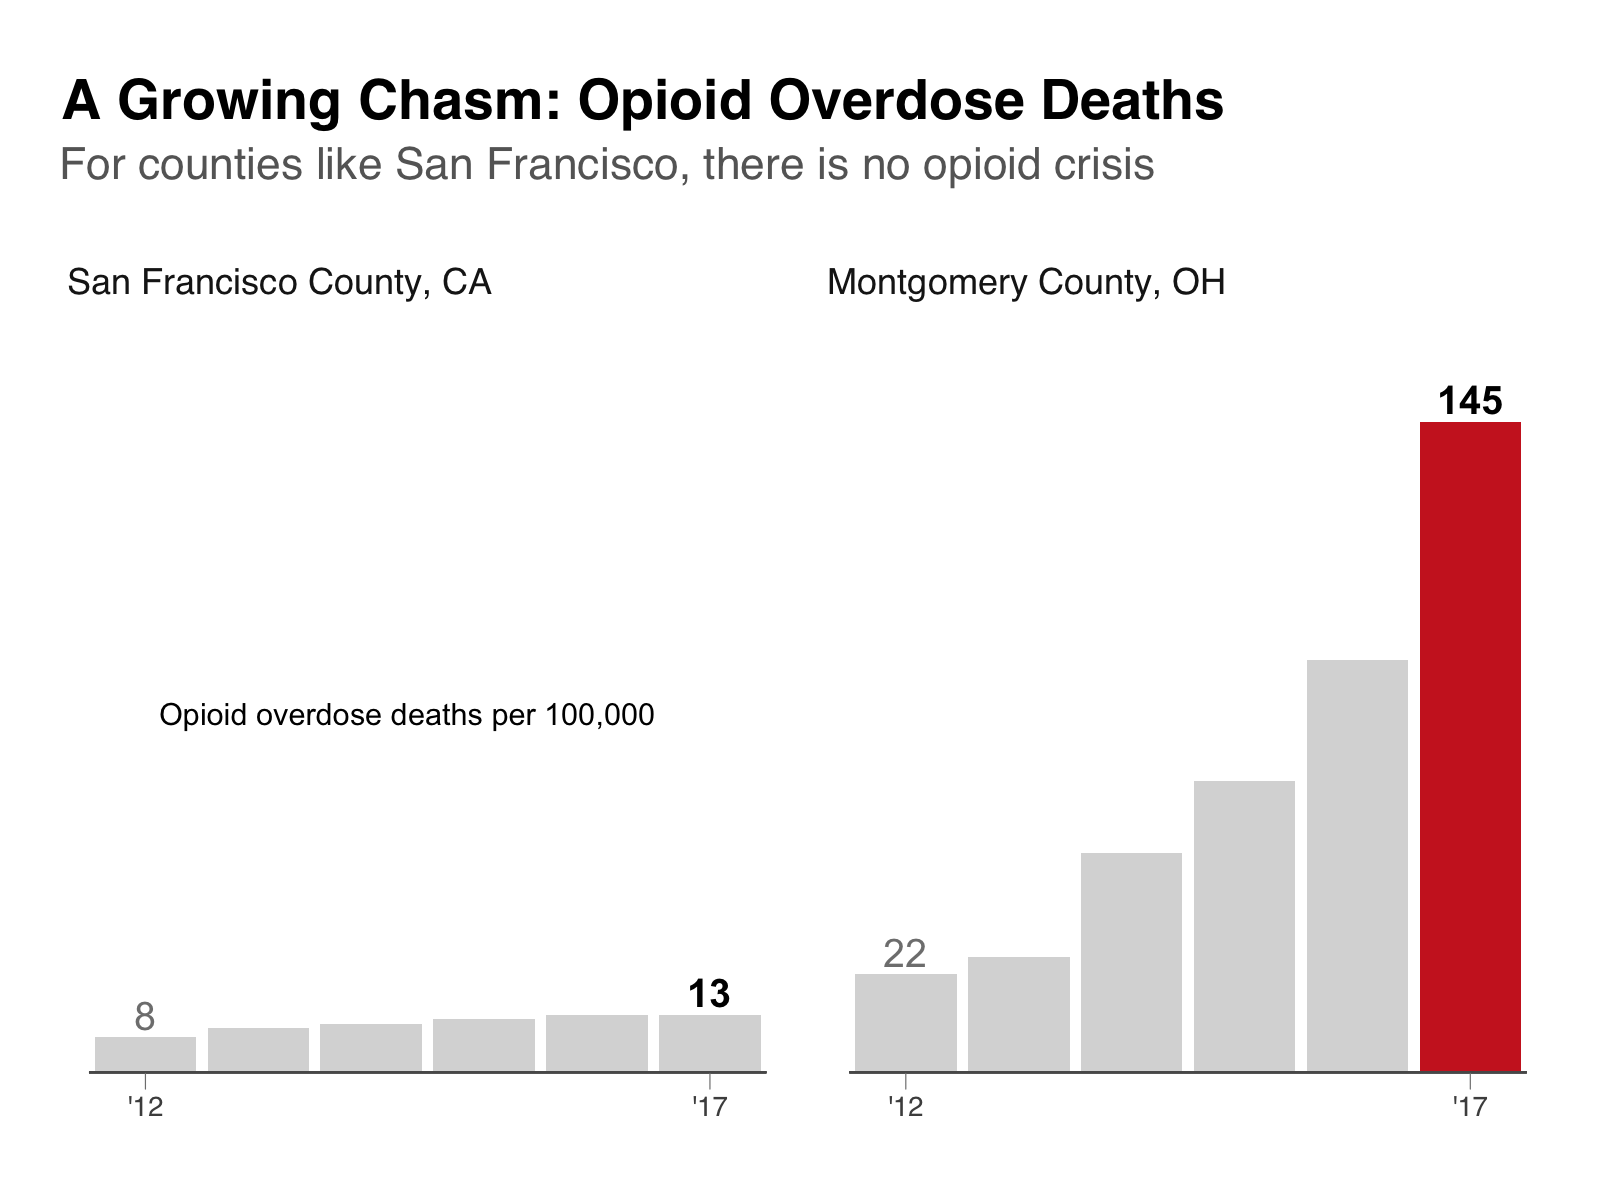

In [10]:
%%R -h 6 -w 8 -u in -r 200

# Base
q <- ggplot(data = sf_montg, aes(x = Year, y = Rate))

# Geoms
q <- q + geom_col(fill = bar_fill)

# Title
q <- q + labs(title = "A Growing Chasm: Opioid Overdose Deaths")
q <- q + labs(subtitle = "For counties like San Francisco, there is no opioid crisis\n")

# Annotations
q <- q + geom_text(data = anno, aes(x = x1, y = y1, label = labs), fontface = faces, colour = colours, size = 5)
q <- q + geom_text(data = anno2, aes(x = x2, y = y2, label = "Opioid overdose deaths per 100,000"), hjust=0.2)

# Axes
q <- q + geom_segment(aes(x = 2011.5, y = 0, xend = 2017.5, yend = 0), colour = "grey35", size = 0.7)
q <- q + scale_x_continuous(breaks = c(2012, 2017), labels = c("'12", "'17"))
q <- q + scale_y_continuous(limits = c(0, 170), expand = c(0,0))

# Facets
q <- q + facet_grid(col = vars(County))

# Themes
q <- q + theme_minimal() + theme_custom

q

R[write to console]: Saving 8 x 6 in image



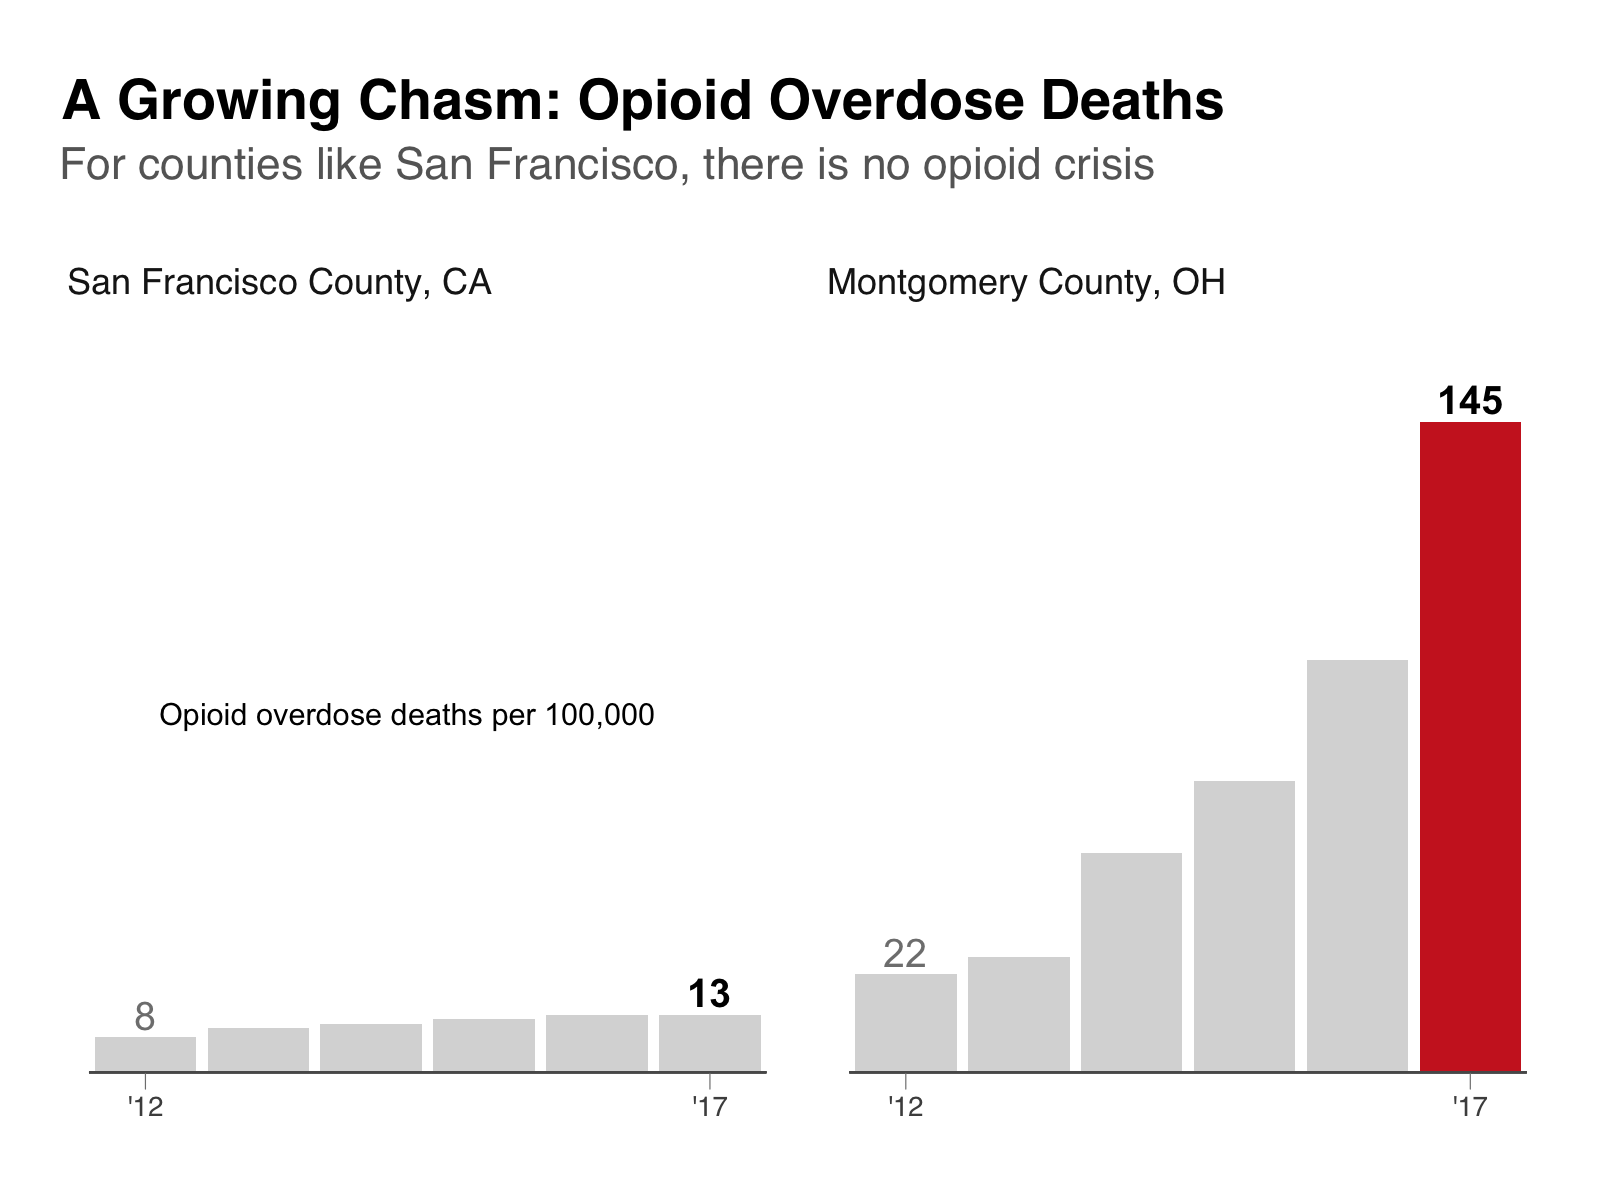

In [12]:
%%R -h 6 -w 8 -u in -r 200

# Save plot
q + ggsave('../output/chasm.png', device = 'png')